In [1]:
import pandas as pd
df = pd.read_csv("Electric_Production.csv")
df

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [2]:
df.dtypes

DATE           object
IPG2211A2N    float64
dtype: object

In [3]:
df = df.rename(columns = {"IPG2211A2N":"value", "DATE":"timestamp"})
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.dtypes

timestamp    datetime64[ns]
value               float64
dtype: object

<Axes: xlabel='timestamp'>

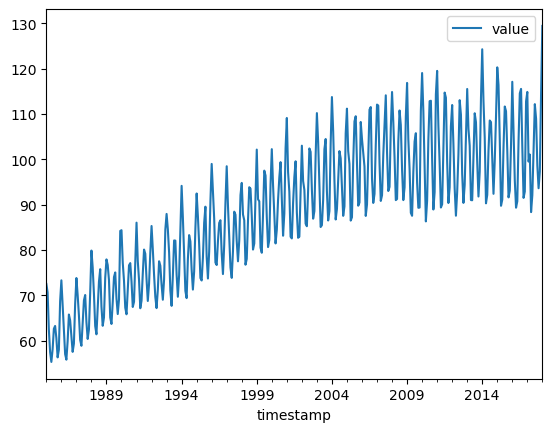

In [4]:
df.plot(x = "timestamp", y = "value")

In [5]:
from darts import TimeSeries
series = TimeSeries.from_dataframe(df, "timestamp", "value")

In [6]:
train, val = series[:-100], series[-100:]

In [7]:
from darts.models import ExponentialSmoothing
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

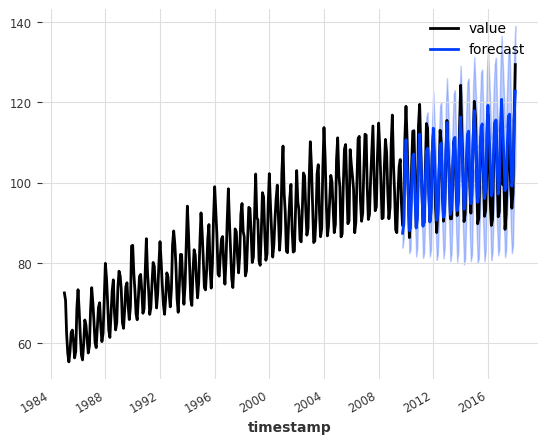

In [8]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [9]:
from scipy.stats import boxcox
df['value'] = boxcox(df['value'], lmbda=0.0)

<Axes: xlabel='timestamp'>

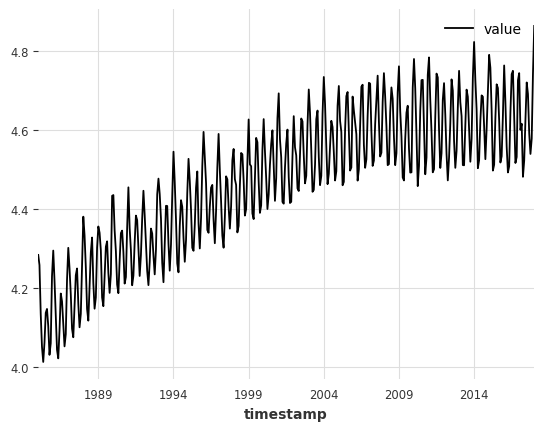

In [10]:
df.plot(x = "timestamp", y = "value")

In [22]:
moving_avg = df["value"].rolling(window=12).mean()
moving_avg 

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
392    4.613704
393    4.615619
394    4.619515
395    4.620945
396    4.630888
Name: value, Length: 397, dtype: float64

In [23]:
moving_avg.isna().sum()

11

In [24]:
moving_avg = moving_avg.dropna()
moving_avg

11     4.125999
12     4.126914
13     4.123686
14     4.123381
15     4.122743
         ...   
392    4.613704
393    4.615619
394    4.619515
395    4.620945
396    4.630888
Name: value, Length: 386, dtype: float64

In [26]:
stat_df = df.copy()
stat_df["value"] = stat_df["value"] - moving_avg
stat_df = stat_df.dropna()
stat_df

,timestamp,value
11,1985-12-01,0.103961
12,1986-01-01,0.167724
13,1986-02-01,0.095629
14,1986-03-01,0.007329
15,1986-04-01,-0.079115
...,...,...
392,2017-09-01,-0.022477
393,2017-10-01,-0.076443
394,2017-11-01,-0.041347
395,2017-12-01,0.121560


<Axes: xlabel='timestamp'>

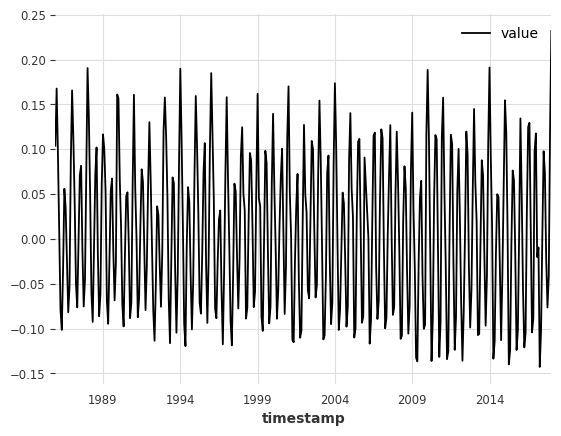

In [27]:
stat_df.plot(x = "timestamp", y = "value")

In [32]:
from statsmodels.tsa.arima.model import ARIMA

In [41]:
train = stat_df[1:len(stat_df.values)-10] 
test = stat_df[len(stat_df.values)-10:]

In [42]:
train

,timestamp,value
12,1986-01-01,0.167724
13,1986-02-01,0.095629
14,1986-03-01,0.007329
15,1986-04-01,-0.079115
16,1986-05-01,-0.101472
...,...,...
382,2016-11-01,-0.088789
383,2016-12-01,0.097767
384,2017-01-01,0.117658
385,2017-02-01,-0.020110


In [43]:
test

,timestamp,value
387,2017-04-01,-0.142741
388,2017-05-01,-0.102643
389,2017-06-01,0.002691
390,2017-07-01,0.097842
391,2017-08-01,0.073579
392,2017-09-01,-0.022477
393,2017-10-01,-0.076443
394,2017-11-01,-0.041347
395,2017-12-01,0.121560
396,2018-01-01,0.232057


In [47]:
from sklearn.metrics import mean_squared_error
model = ARIMA(train["value"], order=(2,1,2))
arima_model = model.fit()

pred = arima_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_squared_error(test["value"], pred)
print('MSE: {}'.format(round(arima_score,4)))

MSE: 0.0023


/Users/senmayur/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senmayur/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senmayur/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senmayur/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senmayur/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No s

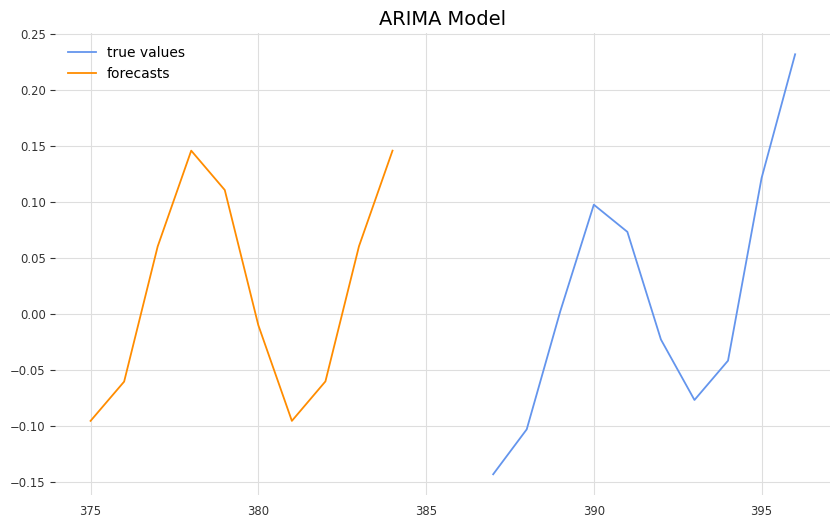

In [52]:
plt.figure(figsize = (10,6))
plt.plot(test["value"], label = "true values", color = "cornflowerblue")
plt.plot(pred,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()